In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection


file_path = "output/electrode_npp_results.npz"

data = np.load(file_path)
nodes = data['nodes']
elements = data['elements']
c1_history = data['c1_history']
c2_history = data['c2_history']
phi_history = data['phi_history']
dt = data['dt'].item()  # Use .item() to get scalar value
num_steps = c1_history.shape[0]
phi_c = data['phi_c'].item()
tau_c = data['tau_c'].item()


In [40]:
#constants = data['constants'].item()

In [41]:
physical_constants = {
        "R": 8.314,
        "T": 400,
        "F": 96485.33212,
        "epsilon": 80,
        "D1": 1e-9,
        "D2": 1e-9,
        "D3": 1e-9,
        "z1": 1,
        "z2": -1,
        "chi": 0,
        "c0": 1.0
    }

In [42]:
from utils.fem_mesh import TriangularMesh 

def calculate_electrode_current(electrode_node_idx, file_path="output/electrode_npp_results.npz"):
    """
    Calculates the current flowing out of a single electrode by integrating the
    current density around a contour enclosing the electrode node.

    Args:
        electrode_node_idx (int): The node index of the electrode to analyze.
        file_path (str): Path to the saved simulation data (.npz file).
    """
    # 1. Load data
    data = np.load(file_path, allow_pickle=True)
    nodes = data['nodes']
    elements = data['elements']
    c1_history = data['c1_history']
    c2_history = data['c2_history']
    phi_history = data['phi_history']
    dt = data['dt'].item()
    num_steps = c1_history.shape[0]
    L_c = data['L_c'].item()

    # Load physical constants
    D1, D2 = physical_constants['D1'], physical_constants['D2']
    z1, z2 = physical_constants['z1'], physical_constants['z2']
    F, R, T = physical_constants['F'], physical_constants['R'], physical_constants['T']
    c0 = physical_constants['c0']
    print("physical_constants: ", physical_constants)

    mesh = TriangularMesh(nodes, elements)
    current_history = []

    # 2. Find all elements connected to the electrode node
    connected_elements_indices = [i for i, elem in enumerate(elements) if electrode_node_idx in elem]

    # 3. Loop over each time step
    for step in range(num_steps):
        c1 = c1_history[step]
        c2 = c2_history[step]
        phi = phi_history[step]
        total_current_at_step = 0.0

        # 4. Loop over the elements connected to our electrode
        for elem_idx in connected_elements_indices:
            elem_nodes = elements[elem_idx]
            
            # --- Calculate element-wise current density J_elem ---
            c1_local = c1[elem_nodes]
            c2_local = c2[elem_nodes]
            phi_local = phi[elem_nodes]

            grads_dimless = mesh._element_data[elem_idx]['grads']
            grad_c1 = np.dot(c1_local, grads_dimless)
            grad_c2 = np.dot(c2_local, grads_dimless)
            grad_phi = np.dot(phi_local, grads_dimless)

            c1_avg = np.mean(c1_local) * c0
            c2_avg = np.mean(c2_local) * c0
            
            flux1 = -D1 * grad_c1 - (z1 * F * D1 / (R * T)) * c1_avg * grad_phi
            flux2 = -D2 * grad_c2 - (z2 * F * D2 / (R * T)) * c2_avg * grad_phi
            J_elem = F * (z1 * flux1 + z2 * flux2)

            # 5. Integrate J . n over the boundary of the control volume within this element
            # The control volume boundary here consists of the two element edges that meet at the electrode node.
            
            # Find the local index (0, 1, or 2) of our electrode within the element
            local_node_idx = np.where(elem_nodes == electrode_node_idx)[0][0]
            
            # Get the other two local indices
            other_indices = [i for i in range(3) if i != local_node_idx]
            
            # The two edges of the contour are (p_electrode, p_other1) and (p_electrode, p_other2)
            p_electrode = nodes[electrode_node_idx]
            p_other1 = nodes[elem_nodes[other_indices[0]]]
            p_other2 = nodes[elem_nodes[other_indices[1]]]
            
            # Process edge 1: (p_electrode -> p_other1)
            edge1_vec = p_other1 - p_electrode
            edge1_len = np.linalg.norm(edge1_vec)
            # Outward normal (rotated 90 degrees clockwise)
            edge1_normal = np.array([edge1_vec[1], -edge1_vec[0]]) / edge1_len
            total_current_at_step += np.dot(J_elem, edge1_normal) * (edge1_len / 2.0) # Flux is shared by two elements

            # Process edge 2: (p_other2 -> p_electrode)
            edge2_vec = p_electrode - p_other2
            edge2_len = np.linalg.norm(edge2_vec)
            edge2_normal = np.array([edge2_vec[1], -edge2_vec[0]]) / edge2_len
            total_current_at_step += np.dot(J_elem, edge2_normal) * (edge2_len / 2.0)


        current_history.append(total_current_at_step)

    # 6. Plot the results
    time_axis = np.arange(num_steps) * dt
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis * 1e9, np.array(current_history), marker='.', linestyle='-', markersize=5)
    plt.title(f"Current from Electrode Node {electrode_node_idx} vs. Time")
    plt.xlabel("Time (ns)")
    plt.ylabel("Total Current (A)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return time_axis, np.array(current_history)

In [43]:
nx, ny = 20, 20
sensing_electrode1_idx = (nx+1)*((ny + 1)//2) + 3*nx//4  # applied voltage
sensing_electrode2_idx = (nx+1)*((ny + 1)//4) + 3*nx//4  # 0 

stimulating_electrode1_idx = (nx+1)*((ny + 1)//2) + nx//4
stimulating_electrode2_idx = (nx+1)*((ny + 1)//4) + nx//4



Calculating current for the first measuring electrode...
physical_constants:  {'R': 8.314, 'T': 400, 'F': 96485.33212, 'epsilon': 80, 'D1': 1e-09, 'D2': 1e-09, 'D3': 1e-09, 'z1': 1, 'z2': -1, 'chi': 0, 'c0': 1.0}


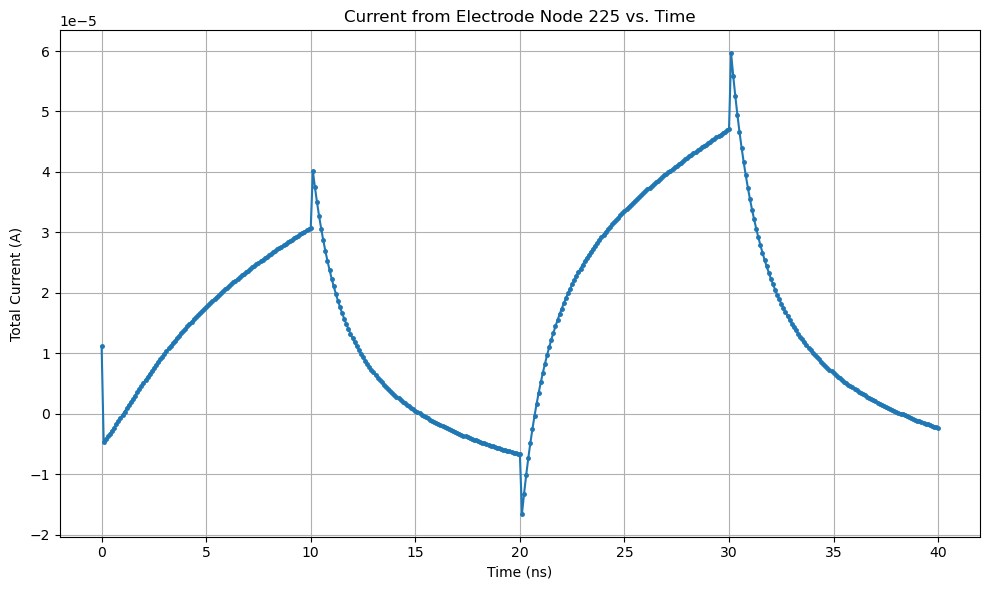


Calculating current for the second measuring electrode...
physical_constants:  {'R': 8.314, 'T': 400, 'F': 96485.33212, 'epsilon': 80, 'D1': 1e-09, 'D2': 1e-09, 'D3': 1e-09, 'z1': 1, 'z2': -1, 'chi': 0, 'c0': 1.0}


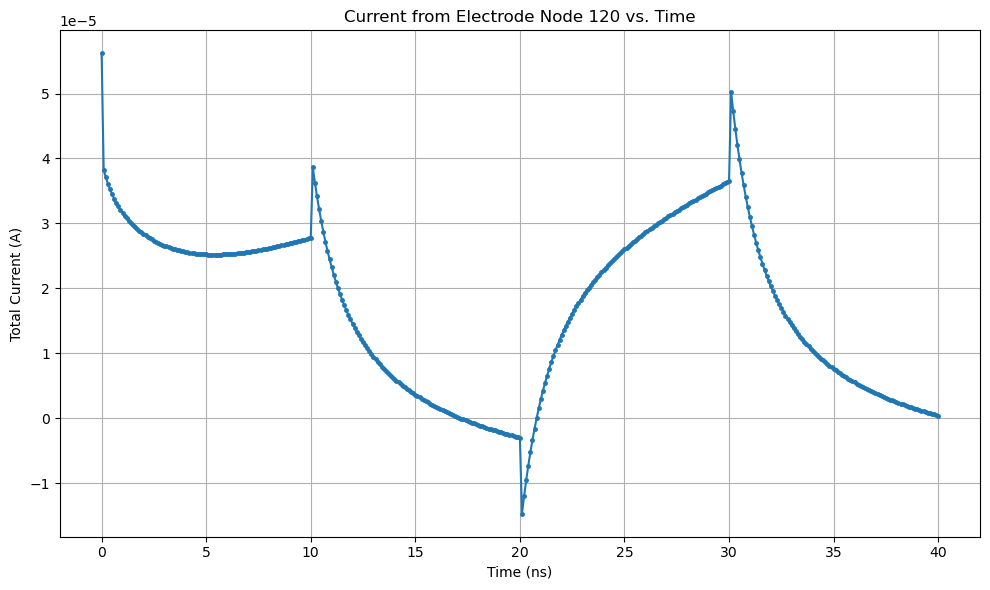

physical_constants:  {'R': 8.314, 'T': 400, 'F': 96485.33212, 'epsilon': 80, 'D1': 1e-09, 'D2': 1e-09, 'D3': 1e-09, 'z1': 1, 'z2': -1, 'chi': 0, 'c0': 1.0}


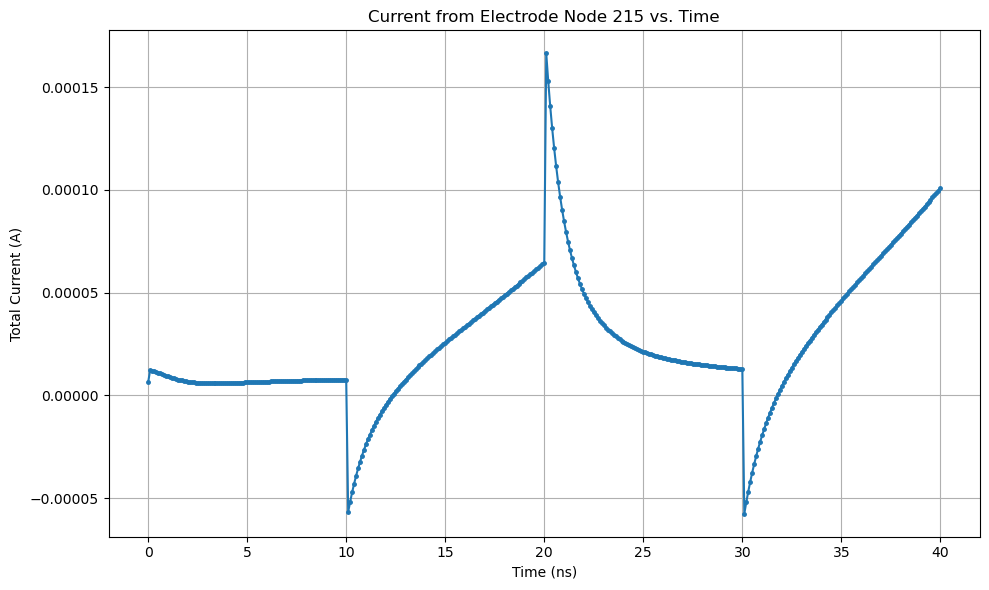

physical_constants:  {'R': 8.314, 'T': 400, 'F': 96485.33212, 'epsilon': 80, 'D1': 1e-09, 'D2': 1e-09, 'D3': 1e-09, 'z1': 1, 'z2': -1, 'chi': 0, 'c0': 1.0}


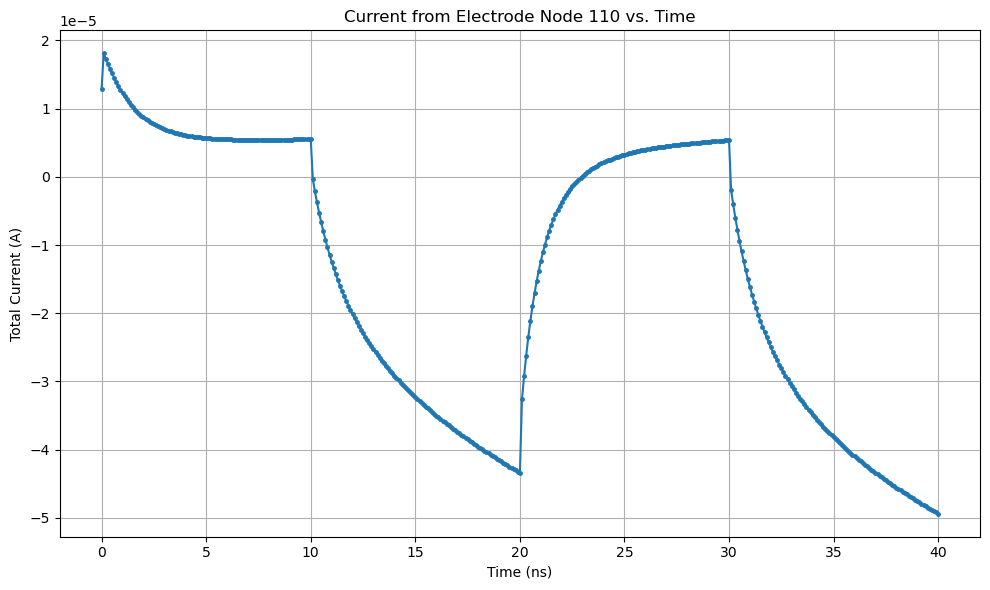

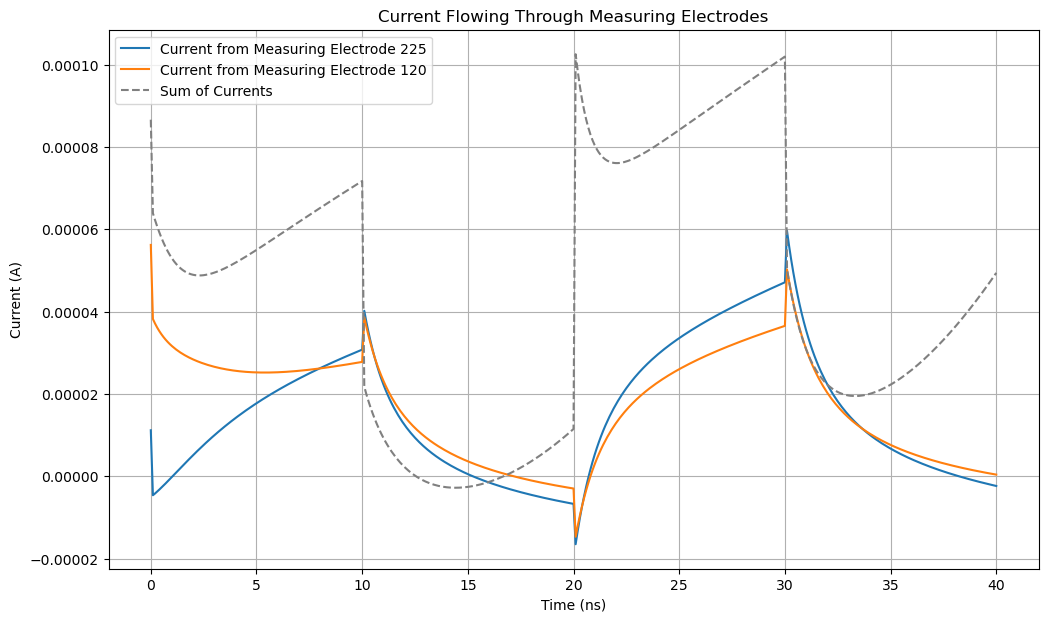

In [44]:
print("\nCalculating current for the first measuring electrode...")
t_sense1, I_sense1 = calculate_electrode_current(sensing_electrode1_idx)

print("\nCalculating current for the second measuring electrode...")
t_sense2, I_sense2 = calculate_electrode_current(sensing_electrode2_idx)

t_stim1, I_stim1 = calculate_electrode_current(stimulating_electrode1_idx)
t_stim2, I_stim2 = calculate_electrode_current(stimulating_electrode2_idx)


# Plotting them together shows the relationship
plt.figure(figsize=(12, 7))
plt.plot(t_sense1 * 1e9, I_sense1, label=f'Current from Measuring Electrode {sensing_electrode1_idx}')
plt.plot(t_sense2 * 1e9, I_sense2, label=f'Current from Measuring Electrode {sensing_electrode2_idx}')
#plt.plot(t_stim1 * 1e9, I_stim1, label=f'Current from Stimulating Electrode {stimulating_electrode1_idx}')
#plt.plot(t_stim2 * 1e9, I_stim2, label=f'Current from Stimulating Electrode {stimulating_electrode2_idx}')
    
    # The sum should be close to zero if they are an isolated pair
plt.plot(t_sense1 * 1e9, I_sense1 + I_sense2 + I_stim1 + I_stim2, label='Sum of Currents', linestyle='--', color='gray')
    
plt.title("Current Flowing Through Measuring Electrodes")
plt.xlabel("Time (ns)")
plt.ylabel("Current (A)")
plt.legend()
plt.grid(True)
plt.show()